# **UNet Segmentation - Mitochondria EM  - Synthetic Dataset**

## Important Note:

- Get Dataset from [Mitochondria EM Segmentation - Synthetic Dataset](https://www.kaggle.com/datasets/iabdullahali/mitochondria-em-segmentation-synthetic-dataset/data)
- This notebook was created using [Google Colab](https://colab.google/).

In [ ]:
# Install required packages
%pip install torch torchvision
%pip install segmentation-models-pytorch
%pip install albumentations
%pip install matplotlib numpy tqdm opencv-python
%pip install scikit-learn scikit-image
%pip install -q torchinfo

import os
import zipfile
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
from torchinfo import summary

print("Dependencies installed and imported successfully!")

Dependencies installed and imported successfully!


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# Extract the dataset
zip_path = '/content/syndata_mito.zip'
extract_path = '/content'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
import os

folders = ["images", "pth", "training_sequence"]

for folder in folders:
    os.makedirs(folder, exist_ok=True)

In [39]:
# Setup paths
base_path = '/content/syndata_mito'
train_image_dir = os.path.join(base_path, 'train/images')
train_mask_dir = os.path.join(base_path, 'train/masks')
val_image_dir = os.path.join(base_path, 'validate/images')
val_mask_dir = os.path.join(base_path, 'validate/masks')
test_image_dir = os.path.join(base_path, 'test/images')
test_mask_dir = os.path.join(base_path, 'test/masks')

print("Dataset extracted successfully!")
print(f"Train images: {len(os.listdir(train_image_dir))}")
print(f"Train masks: {len(os.listdir(train_mask_dir))}")
print(f"Validation images: {len(os.listdir(val_image_dir))}")
print(f"Test images: {len(os.listdir(test_image_dir))}")

Dataset extracted successfully!
Train images: 1000
Train masks: 1000
Validation images: 200
Test images: 5


In [40]:
# Dataset class with enhanced functionality
class MitochondriaDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

        # Get sorted lists of images and masks
        self.images = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])
        self.masks = sorted([f for f in os.listdir(mask_dir) if f.endswith('.png')])

        # Verify correspondence
        self.verify_file_correspondence()

    def verify_file_correspondence(self):
        """Verify that each image has a corresponding mask"""
        print("Verifying file correspondence...")
        valid_pairs = []

        for img_name in self.images:
            # Try different mask naming patterns
            possible_mask_names = [
                img_name.replace('.png', '_mask.png'),
                img_name.replace('mito_em_', 'mito_em_mask_'),
                img_name  # Some datasets might have same names
            ]

            found = False
            for mask_name in possible_mask_names:
                if mask_name in self.masks:
                    valid_pairs.append((img_name, mask_name))
                    found = True
                    break

            if not found:
                print(f"Warning: No mask found for image {img_name}")

        self.images = [pair[0] for pair in valid_pairs]
        self.masks = [pair[1] for pair in valid_pairs]
        print(f"Found {len(self.images)} valid image-mask pairs")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        mask_name = self.masks[idx]

        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, mask_name)

        # Load image
        image = cv2.imread(img_path)
        if image is None:
            raise ValueError(f"Failed to load image: {img_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Load mask and ensure it's binary
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise ValueError(f"Failed to load mask: {mask_path}")

        # Double-check binarization
        if mask.max() > 1:
            mask = (mask > 127).astype(np.uint8)
        else:
            mask = mask.astype(np.uint8)

        if self.transform is not None:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

    def visualize_sample(self, idx=0):
        """Visualize a sample from the dataset"""
        image, mask = self[idx]

        if isinstance(image, torch.Tensor):
            image = image.permute(1, 2, 0).numpy()
            image = (image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])) * 255
            image = image.astype(np.uint8)
            mask = mask.numpy()

        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        axes[0].imshow(image)
        axes[0].set_title('Input Image')
        axes[0].axis('off')

        axes[1].imshow(mask, cmap='gray')
        axes[1].set_title('Ground Truth Mask')
        axes[1].axis('off')

        axes[2].imshow(image)
        axes[2].imshow(mask, cmap='jet', alpha=0.5)
        axes[2].set_title('Overlay')
        axes[2].axis('off')

        plt.tight_layout()
        plt.show()

        print(f"Image shape: {image.shape}, Mask shape: {mask.shape}")
        print(f"Mask unique values: {np.unique(mask)}")
        print(f"Mask value range: {mask.min()} - {mask.max()}")

In [19]:
# Define transformations for 512x512 images
train_transform = A.Compose([
    A.Resize(512, 512),
    # A.HorizontalFlip(p=0.5),
    # A.VerticalFlip(p=0.5),
    # A.RandomRotate90(p=0.5),
    # A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.GaussNoise(p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(512, 512),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

print("Dataset class defined successfully!")

Dataset class defined successfully!


Verifying file correspondence...
Found 1000 valid image-mask pairs
Verifying file correspondence...
Found 200 valid image-mask pairs
Verifying file correspondence...
Found 5 valid image-mask pairs
Training samples: 1000
Validation samples: 200
Test samples: 5

Training dataset sample:


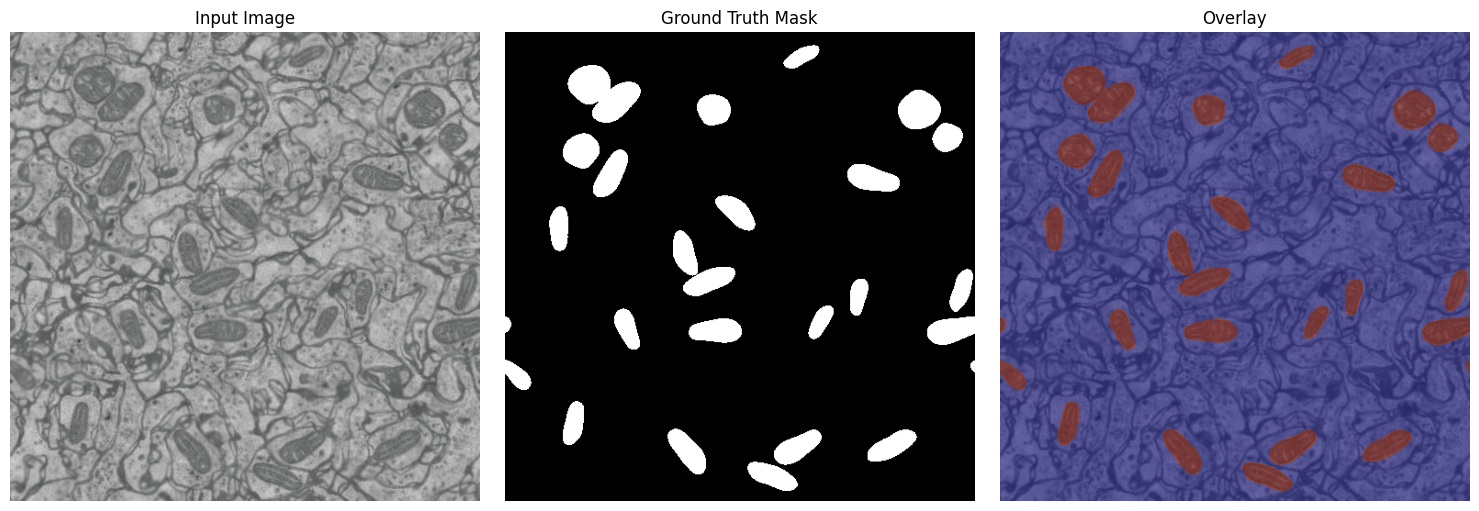

Image shape: (512, 512, 3), Mask shape: (512, 512)
Mask unique values: [0 1]
Mask value range: 0 - 1

Validation dataset sample:


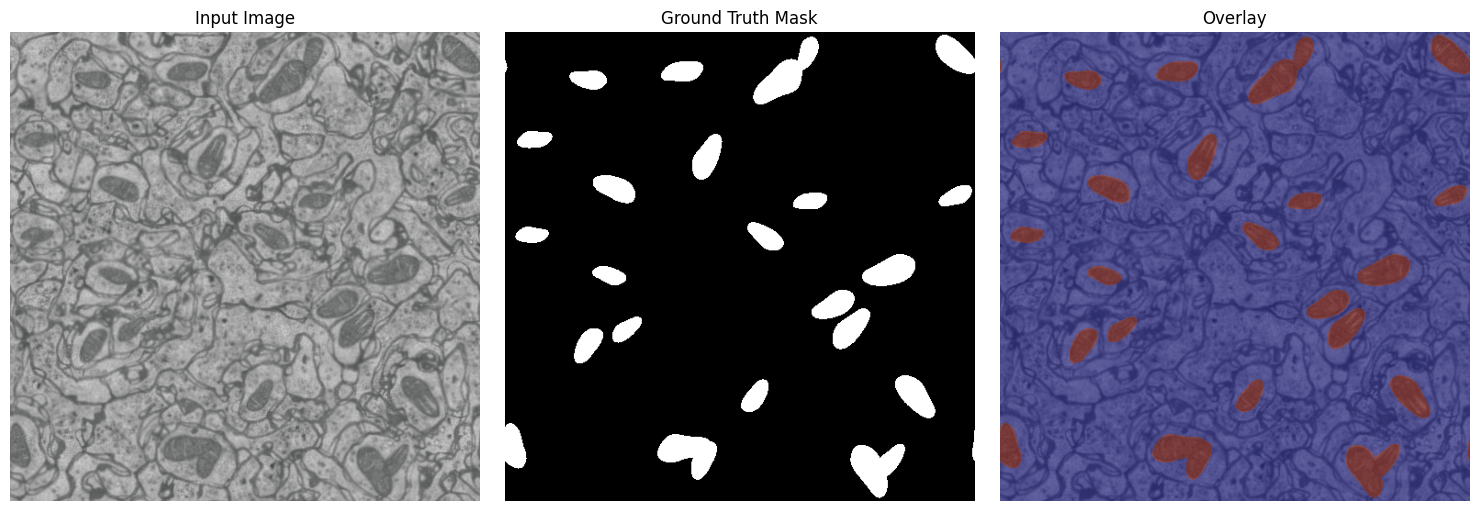

Image shape: (512, 512, 3), Mask shape: (512, 512)
Mask unique values: [0 1]
Mask value range: 0 - 1

Test dataset sample:


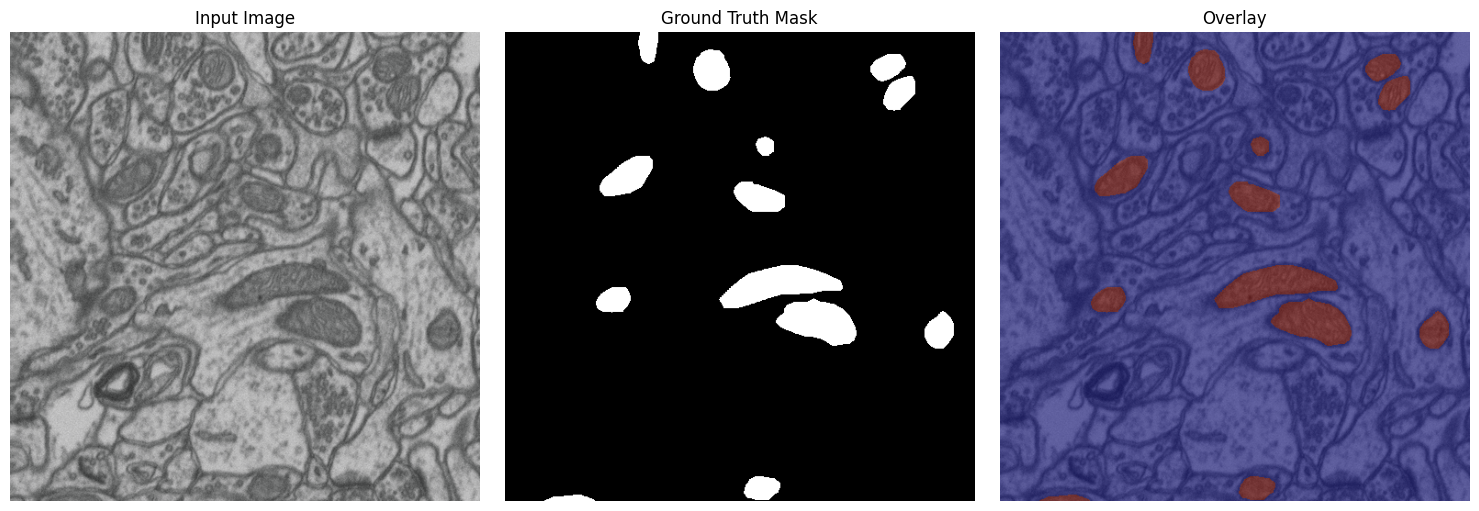

Image shape: (512, 512, 3), Mask shape: (512, 512)
Mask unique values: [0 1]
Mask value range: 0 - 1


In [41]:
# Create datasets
train_dataset = MitochondriaDataset(train_image_dir, train_mask_dir, transform=train_transform)
val_dataset = MitochondriaDataset(val_image_dir, val_mask_dir, transform=val_transform)
test_dataset = MitochondriaDataset(test_image_dir, test_mask_dir, transform=val_transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Visualize samples from each dataset
print("\nTraining dataset sample:")
train_dataset.visualize_sample(0)

print("\nValidation dataset sample:")
val_dataset.visualize_sample(0)

print("\nTest dataset sample:")
test_dataset.visualize_sample(0)

In [23]:
# Define U-Net model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation=None,
).to(device)

# Print model architecture
print("Model Architecture: U-Net with ResNet34 encoder")

# Use torchinfo for summary (safe alternative)
try:
    summary(model, input_size=(1, 3, 512, 512), device=device.type, verbose=0)
except Exception as e:
    print(f"Could not generate detailed summary: {e}")
    print("Using simple parameter count...")

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

print("Model defined successfully!")

Using device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

Model Architecture: U-Net with ResNet34 encoder
Total parameters: 24,436,369
Trainable parameters: 24,436,369
Model defined successfully!


In [ ]:
# Training function with visualization
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=25):
    train_losses = []
    val_losses = []
    val_iou_scores = []
    val_dice_scores = []

    best_iou = 0.0
    best_model_wts = None

    # Create directories for saving images
    os.makedirs('training_sequence', exist_ok=True)
    os.makedirs('images', exist_ok=True)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Training phase
        model.train()
        running_loss = 0.0
        train_progress = tqdm(train_loader, desc="Training")

        for images, masks in train_progress:
            images = images.to(device)
            masks = masks.float().to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks.unsqueeze(1))

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            train_progress.set_postfix({'loss': loss.item()})

        epoch_loss = running_loss / len(train_dataset)
        train_losses.append(epoch_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        iou_scores = []
        dice_scores = []

        val_progress = tqdm(val_loader, desc="Validation")
        with torch.no_grad():
            for images, masks in val_progress:
                images = images.to(device)
                masks = masks.float().to(device)

                outputs = model(images)
                loss = criterion(outputs, masks.unsqueeze(1))
                val_loss += loss.item() * images.size(0)

                # Calculate metrics
                preds = torch.sigmoid(outputs) > 0.5
                preds_flat = preds.cpu().numpy().astype(np.uint8).flatten()
                masks_flat = masks.cpu().numpy().astype(np.uint8).flatten()

                # IoU
                intersection = np.logical_and(preds_flat, masks_flat).sum()
                union = np.logical_or(preds_flat, masks_flat).sum()
                iou = intersection / union if union > 0 else 0
                iou_scores.append(iou)

                # Dice coefficient
                dice = (2 * intersection) / (np.sum(preds_flat) + np.sum(masks_flat)) if (np.sum(preds_flat) + np.sum(masks_flat)) > 0 else 0
                dice_scores.append(dice)

                val_progress.set_postfix({'iou': iou, 'dice': dice})

        avg_val_loss = val_loss / len(val_dataset)
        avg_iou = np.mean(iou_scores) if iou_scores else 0
        avg_dice = np.mean(dice_scores) if dice_scores else 0

        val_losses.append(avg_val_loss)
        val_iou_scores.append(avg_iou)
        val_dice_scores.append(avg_dice)

        scheduler.step(avg_val_loss)

        print(f'Train Loss: {epoch_loss:.4f}, Val Loss: {avg_val_loss:.4f}, IoU: {avg_iou:.4f}, Dice: {avg_dice:.4f}')

        # Create and save plot for this epoch
        plt.figure(figsize=(9, 3))
        
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Training Loss', marker='o')
        plt.plot(val_losses, label='Validation Loss', marker='o')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(val_iou_scores, label='IoU', marker='s', color='green')
        plt.plot(val_dice_scores, label='Dice', marker='s', color='blue')
        plt.title('Validation Metrics')
        plt.xlabel('Epoch')
        plt.ylabel('Score')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()
        
        # Save current epoch plot to training_sequence folder
        epoch_plot_path = f'training_sequence/training_plot_epoch_{epoch+1}.png'
        plt.savefig(epoch_plot_path, dpi=300, bbox_inches='tight')
        print(f'Saved plot: {epoch_plot_path}')
        
        plt.close()  # Close the figure to free memory

        # Save best model
        if avg_iou > best_iou:
            best_iou = avg_iou
            best_model_wts = model.state_dict().copy()
            os.makedirs('pth', exist_ok=True)
            torch.save(model.state_dict(), 'pth/best_model.pth')
            print(f'New best model saved with IoU: {best_iou:.4f}')

    # Load best model weights
    if best_model_wts:
        model.load_state_dict(best_model_wts)

    # Create and save final comprehensive plot
    plt.figure(figsize=(9, 3))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', marker='o')
    plt.plot(val_losses, label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(val_iou_scores, label='IoU', marker='s', color='green')
    plt.plot(val_dice_scores, label='Dice', marker='s', color='blue')
    plt.title('Validation Metrics')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    
    # Save final plot to images folder (with single 'r' as requested)
    final_plot_path = 'images/traning_plot.png'
    plt.savefig(final_plot_path, dpi=300, bbox_inches='tight')
    print(f'Saved final plot: {final_plot_path}')
    
    plt.close()  # Close the final figure

    return model, train_losses, val_losses, val_iou_scores, val_dice_scores

print("Training function defined successfully!")

Training function and Evaluation function defined successfully!


In [ ]:
# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_masks = []
    metrics = {
        'iou': [],
        'dice': [],
        'precision': [],
        'recall': [],
        'accuracy': []
    }

    with torch.no_grad():
        test_progress = tqdm(test_loader, desc="Testing")
        for images, masks in test_progress:
            images = images.to(device)
            masks_np = masks.cpu().numpy().astype(np.uint8)

            outputs = model(images)
            preds = torch.sigmoid(outputs) > 0.5
            preds_np = preds.cpu().numpy().astype(np.uint8)

            # Calculate metrics for each image in batch
            batch_ious = []
            for i in range(len(masks_np)):
                pred_flat = preds_np[i].flatten()
                mask_flat = masks_np[i].flatten()

                # IoU
                intersection = np.logical_and(pred_flat, mask_flat).sum()
                union = np.logical_or(pred_flat, mask_flat).sum()
                iou = intersection / union if union > 0 else 0
                metrics['iou'].append(iou)
                batch_ious.append(iou)

                # Dice coefficient
                dice = (2 * intersection) / (np.sum(pred_flat) + np.sum(mask_flat)) if (np.sum(pred_flat) + np.sum(mask_flat)) > 0 else 0
                metrics['dice'].append(dice)

                # Precision, Recall, Accuracy
                tp = np.logical_and(pred_flat, mask_flat).sum()
                fp = np.logical_and(pred_flat, 1 - mask_flat).sum()
                fn = np.logical_and(1 - pred_flat, mask_flat).sum()
                tn = np.logical_and(1 - pred_flat, 1 - mask_flat).sum()

                precision = tp / (tp + fp) if (tp + fp) > 0 else 0
                recall = tp / (tp + fn) if (tp + fn) > 0 else 0
                accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0

                metrics['precision'].append(precision)
                metrics['recall'].append(recall)
                metrics['accuracy'].append(accuracy)

            test_progress.set_postfix({'avg_iou': np.mean(batch_ious)})
            all_preds.extend(preds_np)
            all_masks.extend(masks_np)

    # Calculate average metrics
    avg_metrics = {key: np.mean(values) for key, values in metrics.items()}
    std_metrics = {key: np.std(values) for key, values in metrics.items()}

    return all_preds, all_masks, avg_metrics, std_metrics

print("Evaluation function defined successfully!")

Starting training for 15 epochs...
Epoch 1/15
----------


Validation: 100%|██████████| 50/50 [00:04<00:00, 12.15it/s, iou=0.97, dice=0.985]


Train Loss: 0.0102, Val Loss: 0.0074, IoU: 0.9698, Dice: 0.9846


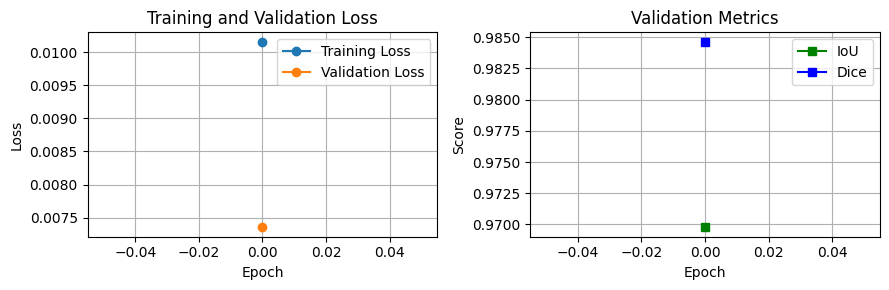

New best model saved with IoU: 0.9698
Epoch 2/15
----------


Validation: 100%|██████████| 50/50 [00:04<00:00, 10.32it/s, iou=0.971, dice=0.985]


Train Loss: 0.0099, Val Loss: 0.0071, IoU: 0.9707, Dice: 0.9851


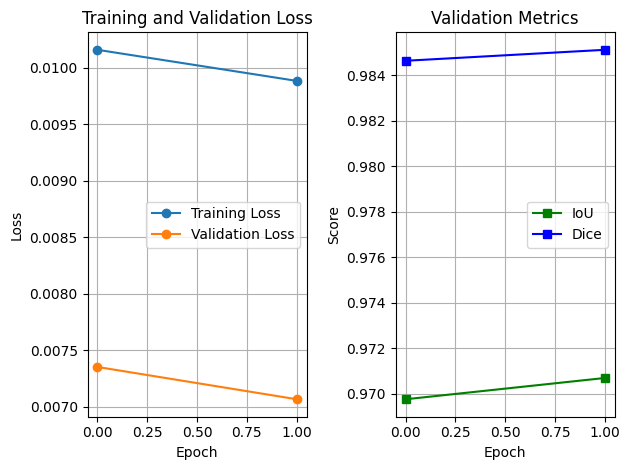

New best model saved with IoU: 0.9707
Epoch 3/15
----------


Validation: 100%|██████████| 50/50 [00:04<00:00, 11.73it/s, iou=0.971, dice=0.985]


Train Loss: 0.0098, Val Loss: 0.0070, IoU: 0.9710, Dice: 0.9853


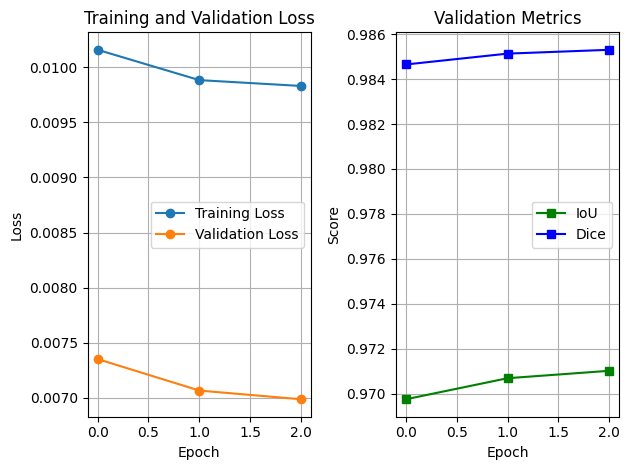

New best model saved with IoU: 0.9710
Epoch 4/15
----------


Validation: 100%|██████████| 50/50 [00:05<00:00,  9.94it/s, iou=0.971, dice=0.985]


Train Loss: 0.0098, Val Loss: 0.0071, IoU: 0.9708, Dice: 0.9852


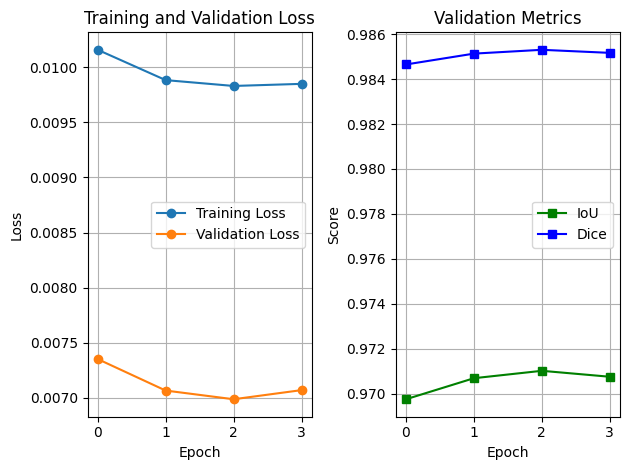

Epoch 5/15
----------


Validation: 100%|██████████| 50/50 [00:04<00:00, 11.49it/s, iou=0.97, dice=0.985]


Train Loss: 0.0097, Val Loss: 0.0072, IoU: 0.9703, Dice: 0.9849


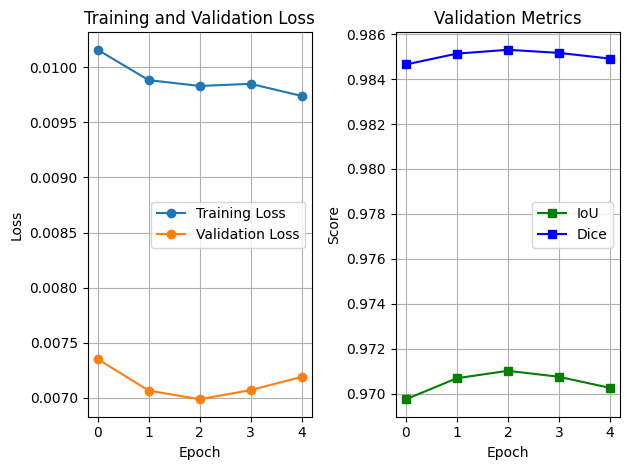

Epoch 6/15
----------


Validation: 100%|██████████| 50/50 [00:05<00:00,  8.96it/s, iou=0.97, dice=0.985]


Train Loss: 0.0097, Val Loss: 0.0072, IoU: 0.9705, Dice: 0.9850


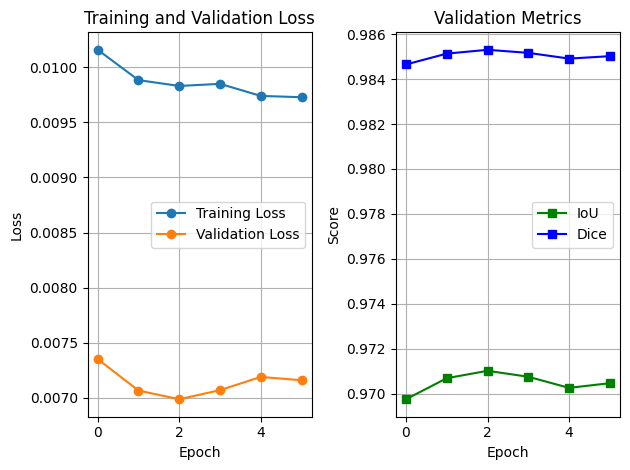

Epoch 7/15
----------


Validation: 100%|██████████| 50/50 [00:04<00:00, 11.35it/s, iou=0.969, dice=0.984]


Train Loss: 0.0098, Val Loss: 0.0071, IoU: 0.9709, Dice: 0.9852


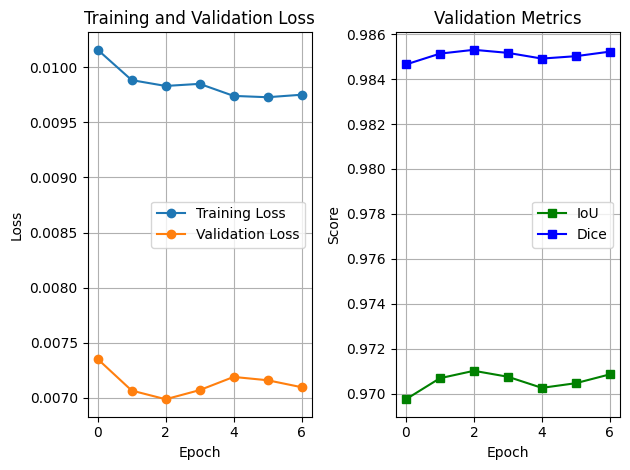

Epoch 8/15
----------


Validation: 100%|██████████| 50/50 [00:04<00:00, 11.36it/s, iou=0.969, dice=0.984]


Train Loss: 0.0096, Val Loss: 0.0070, IoU: 0.9711, Dice: 0.9854


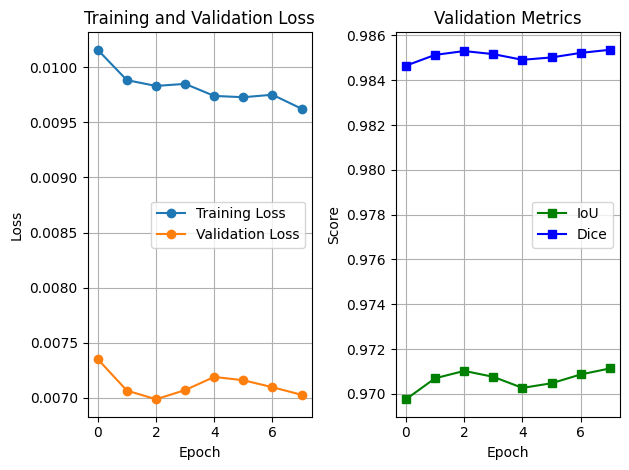

New best model saved with IoU: 0.9711
Epoch 9/15
----------


Validation: 100%|██████████| 50/50 [00:06<00:00,  7.63it/s, iou=0.971, dice=0.985]


Train Loss: 0.0095, Val Loss: 0.0069, IoU: 0.9717, Dice: 0.9856


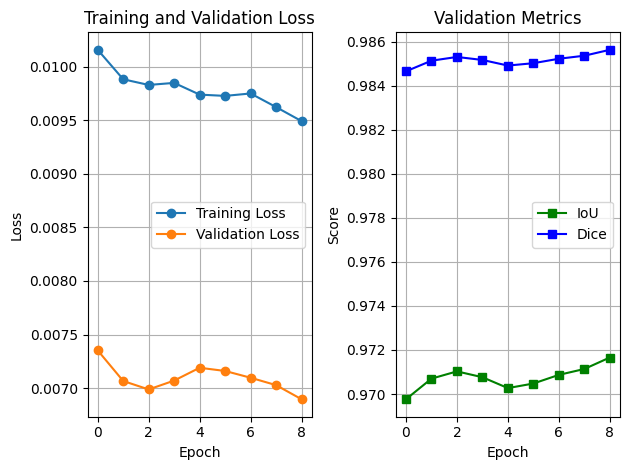

New best model saved with IoU: 0.9717
Epoch 10/15
----------


Validation: 100%|██████████| 50/50 [00:05<00:00,  9.50it/s, iou=0.972, dice=0.986]


Train Loss: 0.0094, Val Loss: 0.0069, IoU: 0.9715, Dice: 0.9855


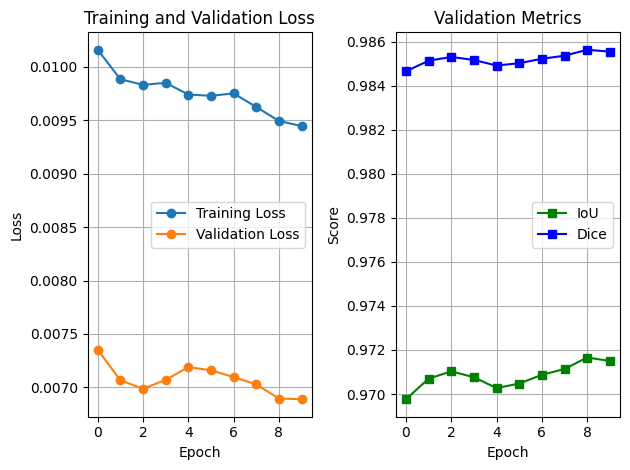

Epoch 11/15
----------


Validation: 100%|██████████| 50/50 [00:04<00:00, 10.21it/s, iou=0.972, dice=0.986]


Train Loss: 0.0094, Val Loss: 0.0068, IoU: 0.9717, Dice: 0.9857


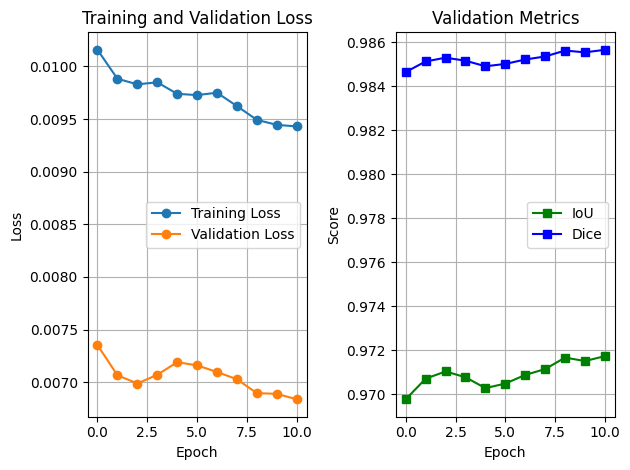

New best model saved with IoU: 0.9717
Epoch 12/15
----------


Validation: 100%|██████████| 50/50 [00:04<00:00, 11.00it/s, iou=0.972, dice=0.986]


Train Loss: 0.0094, Val Loss: 0.0070, IoU: 0.9713, Dice: 0.9854


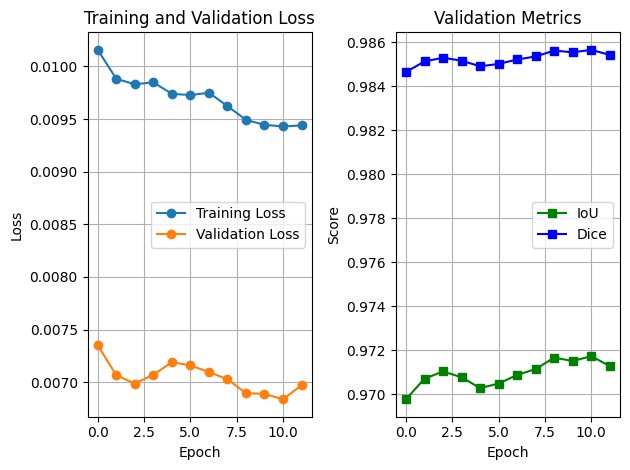

Epoch 13/15
----------


Validation: 100%|██████████| 50/50 [00:05<00:00,  9.59it/s, iou=0.972, dice=0.986]


Train Loss: 0.0094, Val Loss: 0.0069, IoU: 0.9716, Dice: 0.9856


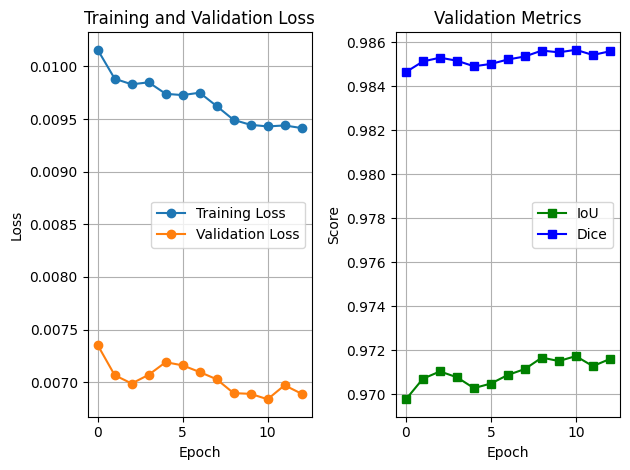

Epoch 14/15
----------


Validation: 100%|██████████| 50/50 [00:04<00:00, 10.42it/s, iou=0.972, dice=0.986]


Train Loss: 0.0094, Val Loss: 0.0068, IoU: 0.9719, Dice: 0.9858


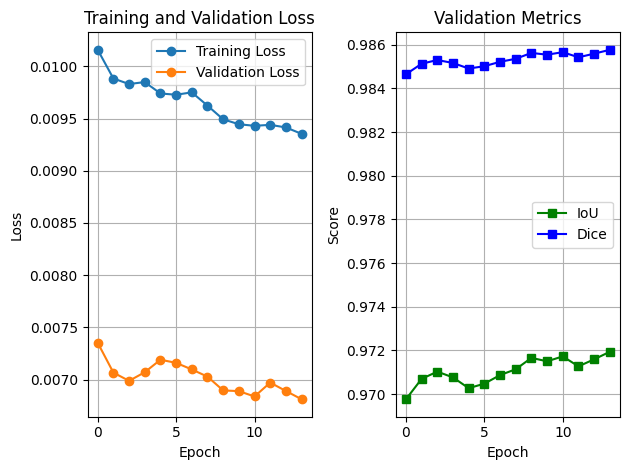

New best model saved with IoU: 0.9719
Epoch 15/15
----------


Validation: 100%|██████████| 50/50 [00:04<00:00, 10.86it/s, iou=0.971, dice=0.985]


Train Loss: 0.0094, Val Loss: 0.0069, IoU: 0.9717, Dice: 0.9857


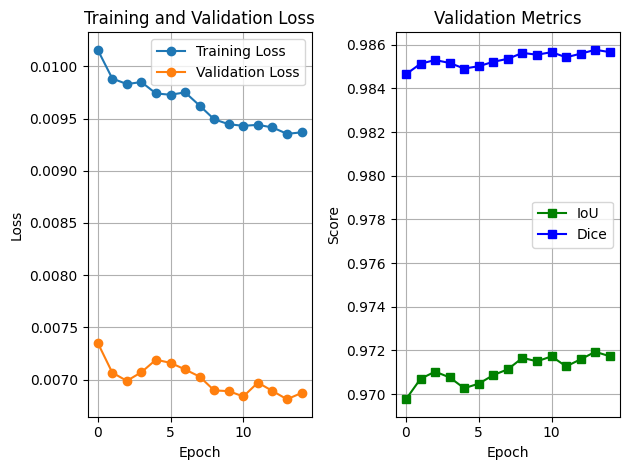

<Figure size 640x480 with 0 Axes>

Training completed successfully!


In [43]:
# Train the model
num_epochs = 15
print(f"Starting training for {num_epochs} epochs...")

model, train_losses, val_losses, val_iou_scores, val_dice_scores = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs
)

print("Training completed successfully!")

Evaluating on validation set...


Testing: 100%|██████████| 50/50 [00:06<00:00,  7.77it/s, avg_iou=0.971]



Validation Metrics (mean ± std):
iou: 0.9717 ± 0.0035
dice: 0.9856 ± 0.0018
precision: 0.9861 ± 0.0029
recall: 0.9851 ± 0.0032
accuracy: 0.9972 ± 0.0004


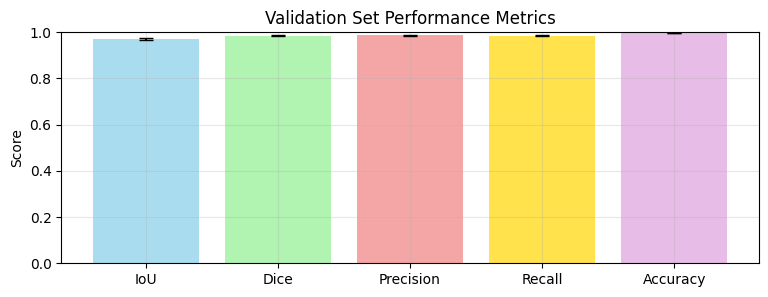

In [44]:
# Evaluate on validation set
print("Evaluating on validation set...")
val_preds, val_masks, val_metrics, val_std = evaluate_model(model, val_loader)

print("\nValidation Metrics (mean \u00b1 std):")
for metric in ['iou', 'dice', 'precision', 'recall', 'accuracy']:
    print(f"{metric}: {val_metrics[metric]:.4f} \u00b1 {val_std[metric]:.4f}")

# Plot metric distribution for validation set (optional, but good for comparison)
plt.figure(figsize=(9, 3))
metrics_names = ['IoU', 'Dice', 'Precision', 'Recall', 'Accuracy']
metrics_values = [val_metrics['iou'], val_metrics['dice'], val_metrics['precision'],
                  val_metrics['recall'], val_metrics['accuracy']]
metrics_std = [val_std['iou'], val_std['dice'], val_std['precision'],
               val_std['recall'], val_std['accuracy']]

plt.bar(metrics_names, metrics_values, yerr=metrics_std, capsize=5, alpha=0.7, color=['skyblue', 'lightgreen', 'lightcoral', 'gold', 'plum'])
plt.title('Validation Set Performance Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
plt.savefig('images/val_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

Evaluating on test set...


Testing: 100%|██████████| 2/2 [00:00<00:00,  4.37it/s, avg_iou=0.264]



Test Metrics (mean ± std):
iou: 0.3774 ± 0.0905
dice: 0.5416 ± 0.0968
precision: 0.3868 ± 0.0916
recall: 0.9322 ± 0.0389
accuracy: 0.9345 ± 0.0079


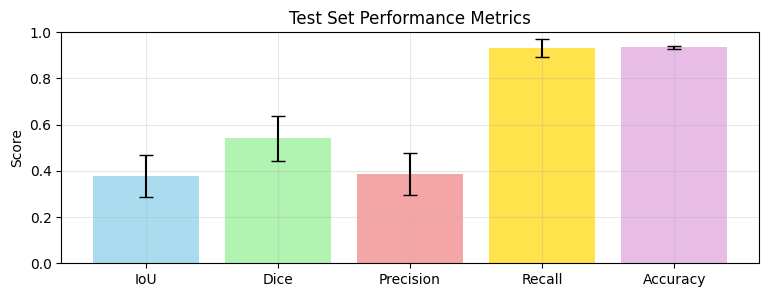

In [45]:
# Evaluate on test set
print("Evaluating on test set...")
test_preds, test_masks, test_metrics, test_std = evaluate_model(model, test_loader)

print("\nTest Metrics (mean ± std):")
for metric in ['iou', 'dice', 'precision', 'recall', 'accuracy']:
    print(f"{metric}: {test_metrics[metric]:.4f} ± {test_std[metric]:.4f}")

# Plot metric distribution
plt.figure(figsize=(9, 3))
metrics_names = ['IoU', 'Dice', 'Precision', 'Recall', 'Accuracy']
metrics_values = [test_metrics['iou'], test_metrics['dice'], test_metrics['precision'],
                  test_metrics['recall'], test_metrics['accuracy']]
metrics_std = [test_std['iou'], test_std['dice'], test_std['precision'],
               test_std['recall'], test_std['accuracy']]

plt.bar(metrics_names, metrics_values, yerr=metrics_std, capsize=5, alpha=0.7, color=['skyblue', 'lightgreen', 'lightcoral', 'gold', 'plum'])
plt.title('Test Set Performance Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
plt.savefig('images/test_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

Visualizing test results...


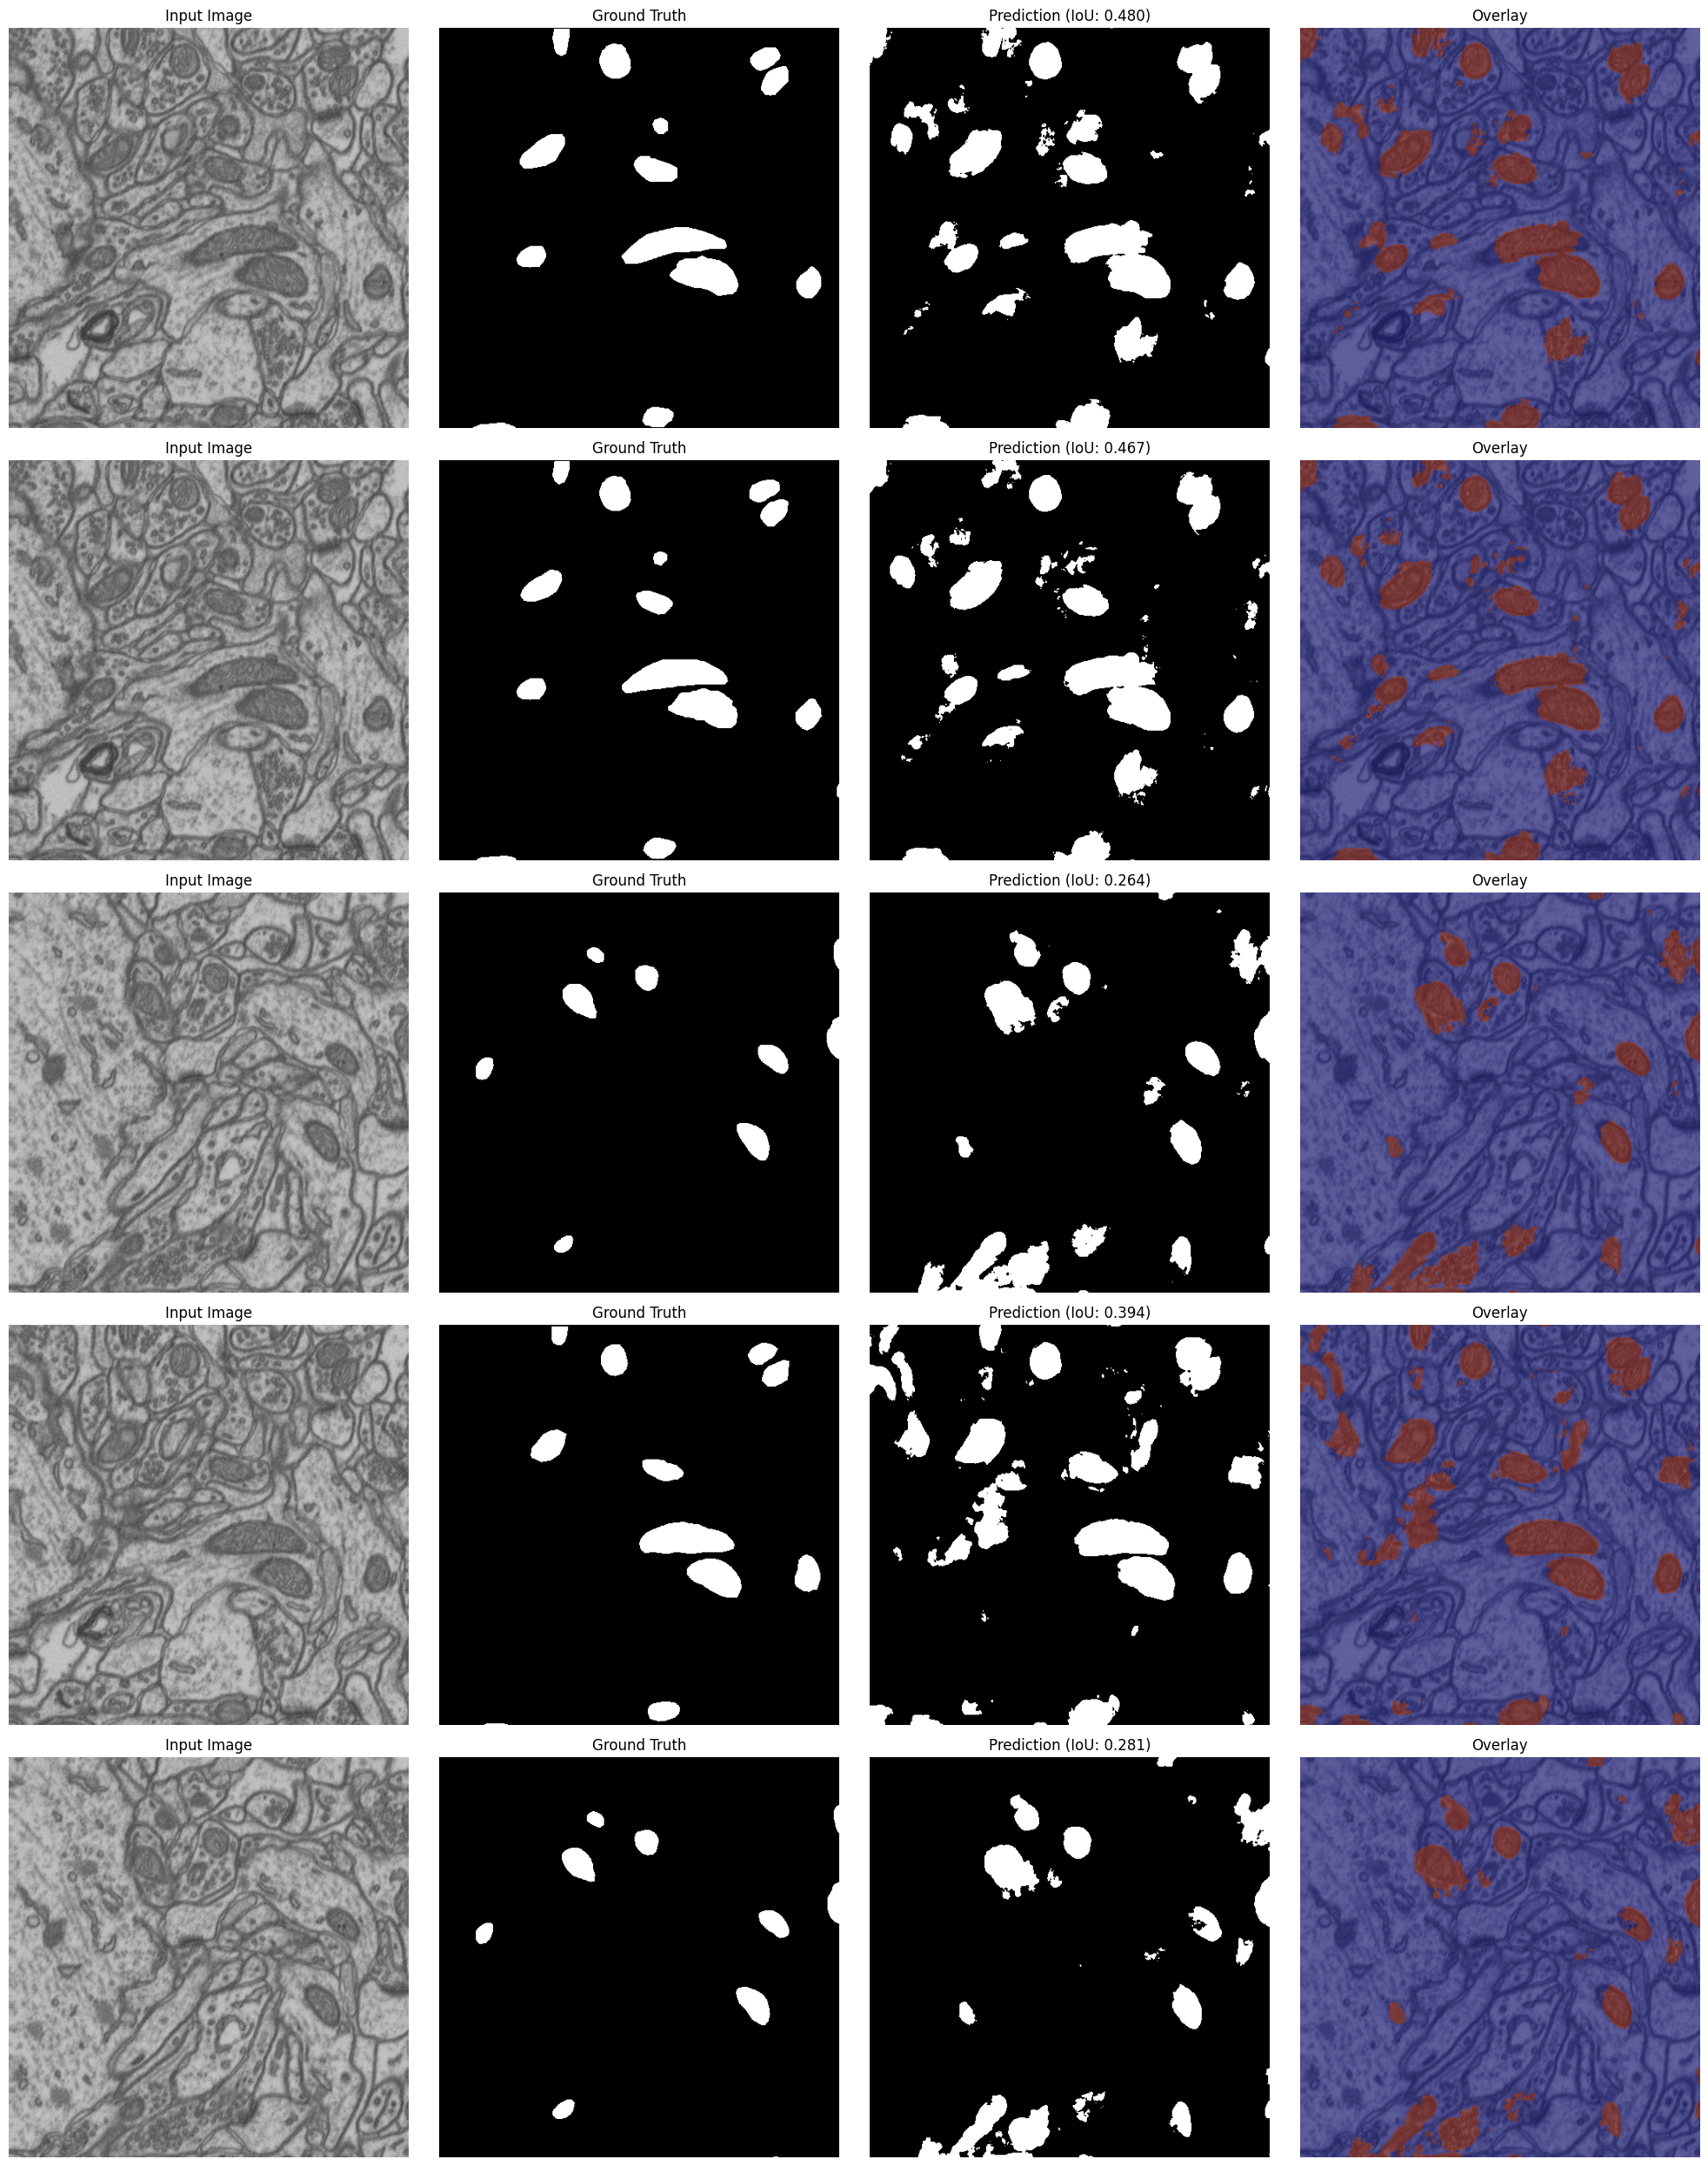

Plotting probability maps...


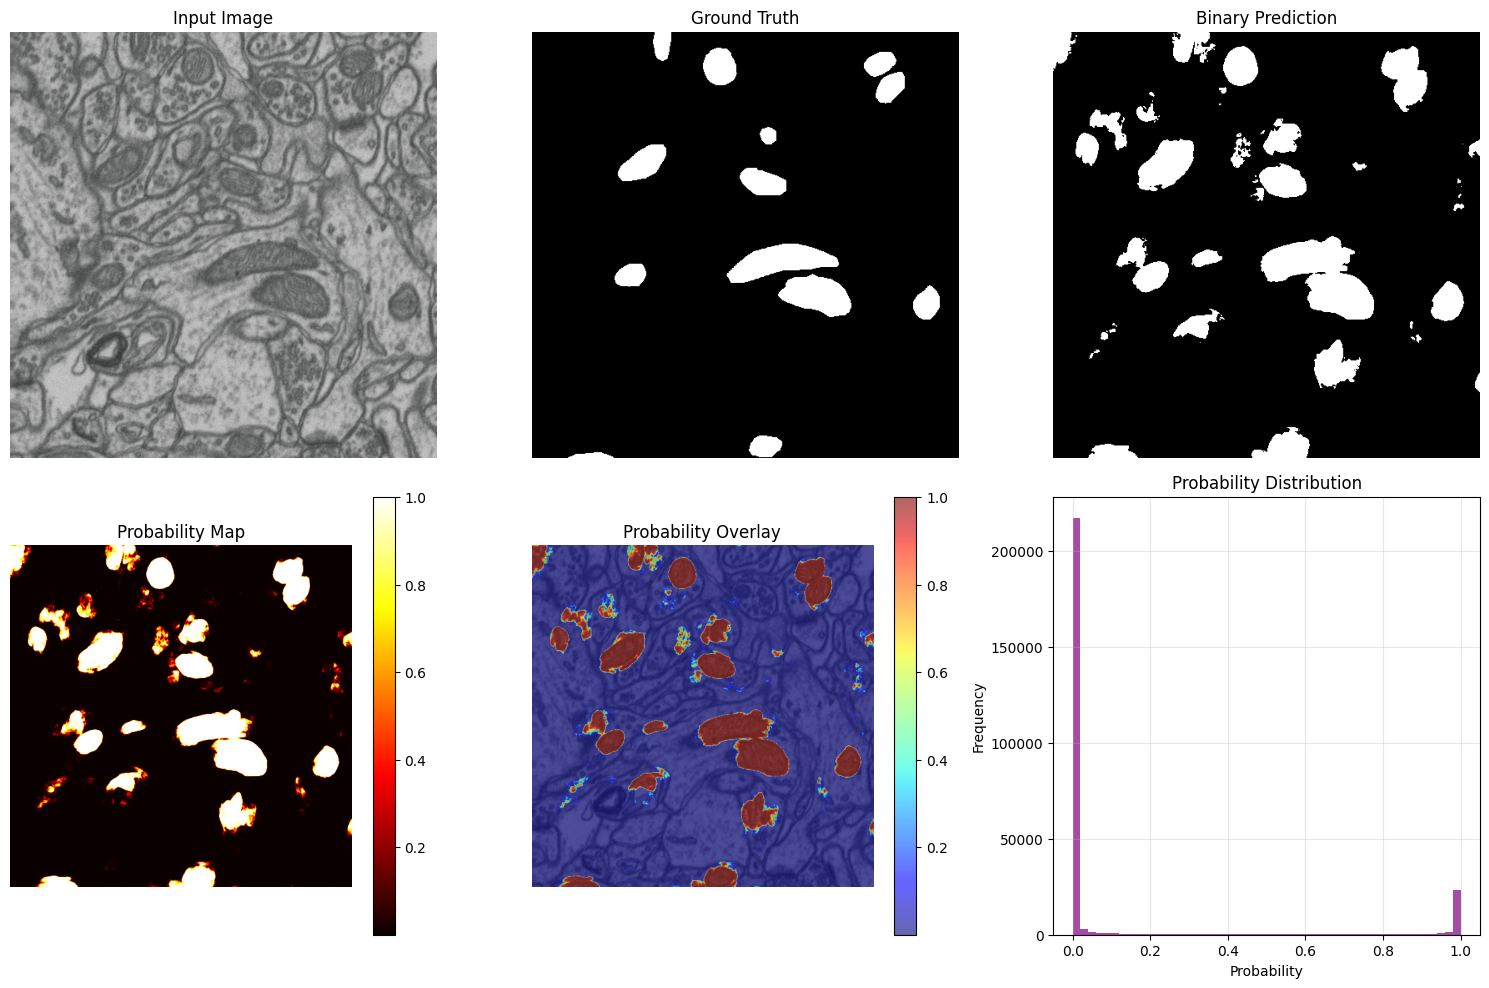

In [49]:
# Visualization function
def visualize_results(model, test_dataset, num_samples=5):
    model.eval()
    indices = np.random.choice(len(test_dataset), num_samples, replace=False)

    fig, axes = plt.subplots(num_samples, 4, figsize=(20, 5*num_samples))

    for i, idx in enumerate(indices):
        image, mask = test_dataset[idx]

        with torch.no_grad():
            input_tensor = image.unsqueeze(0).to(device)
            output = model(input_tensor)
            pred_prob = torch.sigmoid(output)
            pred = pred_prob > 0.5
            pred = pred.squeeze().cpu().numpy().astype(np.uint8)
            pred_prob = pred_prob.squeeze().cpu().numpy()

        # Convert image back to original format
        image = image.permute(1, 2, 0).cpu().numpy()
        image = (image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])) * 255
        image = image.astype(np.uint8)
        mask = mask.cpu().numpy()

        # Calculate IoU for this sample
        intersection = np.logical_and(pred, mask).sum()
        union = np.logical_or(pred, mask).sum()
        sample_iou = intersection / union if union > 0 else 0

        axes[i, 0].imshow(image)
        axes[i, 0].set_title('Input Image')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].set_title('Ground Truth')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(pred, cmap='gray')
        axes[i, 2].set_title(f'Prediction (IoU: {sample_iou:.3f})')
        axes[i, 2].axis('off')

        axes[i, 3].imshow(image)
        axes[i, 3].imshow(pred, cmap='jet', alpha=0.5)
        axes[i, 3].set_title('Overlay')
        axes[i, 3].axis('off')

    plt.tight_layout()
    plt.savefig('images/test_results.png', dpi=300, bbox_inches='tight')
    plt.show()

# Visualize results
print("Visualizing test results...")
visualize_results(model, test_dataset, num_samples=5)

# Additional: Plot probability maps for a sample
def plot_probability_maps(model, test_dataset, idx=0):
    model.eval()
    image, mask = test_dataset[idx]

    with torch.no_grad():
        input_tensor = image.unsqueeze(0).to(device)
        output = model(input_tensor)
        pred_prob = torch.sigmoid(output)
        pred = pred_prob > 0.5

    # Convert to numpy
    image = image.permute(1, 2, 0).cpu().numpy()
    image = (image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])) * 255
    image = image.astype(np.uint8)
    mask = mask.cpu().numpy()
    pred_prob = pred_prob.squeeze().cpu().numpy()
    pred = pred.squeeze().cpu().numpy().astype(np.uint8)

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    axes[0, 0].imshow(image)
    axes[0, 0].set_title('Input Image')
    axes[0, 0].axis('off')

    axes[0, 1].imshow(mask, cmap='gray')
    axes[0, 1].set_title('Ground Truth')
    axes[0, 1].axis('off')

    axes[0, 2].imshow(pred, cmap='gray')
    axes[0, 2].set_title('Binary Prediction')
    axes[0, 2].axis('off')

    prob_map = axes[1, 0].imshow(pred_prob, cmap='hot')
    axes[1, 0].set_title('Probability Map')
    axes[1, 0].axis('off')
    plt.colorbar(prob_map, ax=axes[1, 0])

    axes[1, 1].imshow(image)
    overlay = axes[1, 1].imshow(pred_prob, cmap='jet', alpha=0.6)
    axes[1, 1].set_title('Probability Overlay')
    axes[1, 1].axis('off')
    plt.colorbar(overlay, ax=axes[1, 1])

    axes[1, 2].hist(pred_prob.flatten(), bins=50, alpha=0.7, color='purple')
    axes[1, 2].set_title('Probability Distribution')
    axes[1, 2].set_xlabel('Probability')
    axes[1, 2].set_ylabel('Frequency')
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('images/probability_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

print("Plotting probability maps...")
plot_probability_maps(model, test_dataset, idx=0)

In [48]:
# Save the model and results
import json
from datetime import datetime

# Create results dictionary
results = {
    'timestamp': datetime.now().isoformat(),
    'model_architecture': 'U-Net with ResNet34 encoder',
    'image_size': '512x512',
    'training_samples': len(train_dataset),
    'validation_samples': len(val_dataset),
    'test_samples': len(test_dataset),
    'training_epochs': num_epochs,
    'test_metrics': test_metrics,
    'test_metrics_std': test_std,
    # 'final_val_iou': val_iou_scores[-1] if val_iou_scores else 0,
    # 'final_val_dice': val_dice_scores[-1] if val_dice_scores else 0,
    'val_metrics': val_metrics,
    'val_metrics_std': val_std,
}

# Save results to JSON
with open('training_results.json', 'w') as f:
    json.dump(results, f, indent=4)

# Save model
torch.save({
    'model_state_dict': model.state_dict(),
    'model_architecture': 'U-Net with ResNet34 encoder',
    'training_results': results,
    'timestamp': datetime.now().isoformat()
}, 'pth/mitochondria_em_binary_seg_unet_model_complete.pth')

print("Model and results saved successfully!")
print("\nFinal Results Summary:")
print(f"Test IoU: {test_metrics['iou']:.4f} ± {test_std['iou']:.4f}")
print(f"Test Dice: {test_metrics['dice']:.4f} ± {test_std['dice']:.4f}")
print(f"Test Precision: {test_metrics['precision']:.4f} ± {test_std['precision']:.4f}")
print(f"Test Recall: {test_metrics['recall']:.4f} ± {test_std['recall']:.4f}")
print(f"Final Validation IoU: {val_iou_scores[-1]:.4f}")

Model and results saved successfully!

Final Results Summary:
Test IoU: 0.3774 ± 0.0905
Test Dice: 0.5416 ± 0.0968
Test Precision: 0.3868 ± 0.0916
Test Recall: 0.9322 ± 0.0389
Final Validation IoU: 0.9717
